In [277]:
import torch
import random
import numpy as np
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch.optim as optim
from tqdm.auto import tqdm

In [295]:
class Graph:
    def __init__(self, n=10, alpha=0.5, adj=None):
        self.n = n
        self.v = 0
        self.path = [self.v]
        self.alpha = alpha
        
        def _gen_graph():
            g = torch.zeros((n, n))
            num_ones = int(torch.floor(torch.tensor(alpha * n * n)))
            indices = random.sample(range(n * n), num_ones)
            for index in indices:
                row = index // n
                col = index % n
                g[row, col] = 1
            return g
        
        if adj is None: 
            self.adj = _gen_graph()
        else: 
            self.adj = adj
            
    def show(self):
        G = nx.from_numpy_array(self.adj.numpy(), create_using=nx.DiGraph)
        nx.draw(G, with_labels=True, arrows=True)
        plt.show()
        
    def move(self, w):
        if self.adj[self.v][w] == 0.0:
            # ???
            pass
        self.v = w
        self.path.append(w)
    
    # generates some path
    def generate_sequence(self, v=0, max_len=1000):
        seq = [v]
        for _ in range(max_len):
            ws = torch.nonzero(self.adj[v])
            if ws.size(0) == 0:
                seq.append(n)
                break
            idx = torch.randint(0, ws.size(0), (1,))
            w = ws[idx][0][0].item()
            seq.append(w)
            v = w
        return seq
    
    def generate_one_hot_sequence(self, sequence=None, max_len=1000):
        if sequence is None: sequence = self.generate_sequence(v=0, max_len=max_len)
        xs = torch.zeros( [len(sequence), n + 1], dtype=torch.float64) # !!! N + 1 cause n means dead end
        for t in range(len(sequence)):
            xs[t][sequence[t]] = 1
        return xs.transpose(1, 0)


In [305]:
class SimpleRNN:
    def __init__(self, hidden_size=10, learning_rate=1e-1, vocab_size=n+1):
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.vocab_size = vocab_size

        self.Wxh = torch.tensor(np.random.randn(hidden_size, vocab_size)*0.1, requires_grad=True) # input to hidden
        self.Whh = torch.tensor(np.random.randn(hidden_size, hidden_size)*0.1, requires_grad=True) # hidden to hidden
        self.Why = torch.tensor(np.random.randn(vocab_size, hidden_size)*0.1, requires_grad=True) # hidden to output
        self.bh = torch.tensor(np.random.randn(hidden_size, 1)*0.1, requires_grad=True) # hidden bias
        self.by = torch.tensor(np.random.randn(vocab_size, 1)*0.1, requires_grad=True) # output bias
        
    # v: vocab_size x 1 tensor
    def sample(self, v=None, max_len=10):
        if v is None:
            v = torch.zeros(vocab_size, 1, dtype=torch.float64)
            v[0] = 1
        seq = []
        h = torch.zeros([hidden_size, 1], dtype=torch.float64)
        t = 0
        while True and len(seq) < max_len:
            h = torch.tanh( torch.matmul(Wxh, v).add( torch.matmul( Whh, h).add(bh)))
            y = torch.matmul(Why, h).add(by)
            ps = torch.nn.functional.softmax(y, dim=0)
            i = np.random.choice(range(vocab_size), p=ps.detach().numpy().ravel())
            v = torch.zeros((vocab_size, 1), dtype=torch.float64)
            v[i] = 1.
            seq.append(i)
            if i == n:
                break
        return seq
    
    # inputs : vocab_size x len of sequence
    def loss(self, inputs, targets):
        h = torch.zeros([self.hidden_size, 1], dtype=torch.float64, requires_grad=True)
        h_prev = torch.zeros([self.hidden_size, 1], dtype=torch.float64, requires_grad=True)
        weights = torch.ones(self.vocab_size, dtype=torch.float64)
        loss = torch.zeros([1], dtype=torch.float64, requires_grad=True)
        hidden_states = []

        for t in range(inputs.size()[1]):
            h = torch.tanh( torch.matmul(self.Wxh, inputs[:,[t]]).add( torch.matmul( self.Whh, h_prev).add(self.bh)))
            y = torch.matmul(self.Why, h).add(self.by)
            hidden_states.append(h)
            ps = torch.nn.functional.softmax(y, dim=0)
            loss = loss - (torch.matmul(weights, ps)).mul(torch.log( torch.matmul(torch.transpose(ps, 1, 0), targets[:, [t]])))
            h_prev = h
            
        return loss, hidden_states
    
    def viz(self, hidden_states, states):
        last_hidden_states = hidden_states[-1000:]
        last_states               = states[-1000:]
        states_np = [ h_tensor.detach().numpy() for h_tensor in last_hidden_states]
        states_np = np.asarray(states_np).reshape(-1,hidden_size)

        pca = PCA(n_components=2)
        X_embedded = pca.fit_transform(states_np)

        #tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
        #X_embedded = tsne.fit_transform(states_np)

        fig, ax = plt.subplots()
        scatter = ax.scatter(X_embedded[:,0], X_embedded[:,1], c=last_states, s=1.5)
        #legend1 = ax.legend(handles=scatter.legend_elements()[0],
        #                labels=[PATTERN[:i] for i in range(len(PATTERN+"#"))],
        #                title="STATES")

        #ax.add_artist(legend1)
        plt.show()    
    
    def train(self, g, epochs=1001):
        
        mWxh = torch.zeros_like(self.Wxh)
        mWhh = torch.zeros_like(self.Whh)
        mWhy = torch.zeros_like(self.Why)
        mbh = torch.zeros_like(self.bh)
        mby = torch.zeros_like(self.by)

        for epoch in tqdm(range(epochs)):
            seq = g.generate_one_hot_sequence(max_len=100)
            targets = seq[:,1:]
            inputs  = seq[:,:-1]
            
            loss, hidden_states = self.loss(inputs, targets)
            
            if epoch % 250 == 0:
                self.viz(hidden_states, torch.argmax(inputs, dim=0))
            
            loss.backward()
            with torch.no_grad():
                for param, mem in zip([self.Wxh, self.Whh, self.Why, self.bh, self.by],
                                      [mWxh, mWhh, mWhy, mbh, mby]):
                    mem += param.grad.mul(param.grad )
                    param += -learning_rate * param.grad / torch.sqrt( mem + 1e-8)
                    param.grad.zero_()

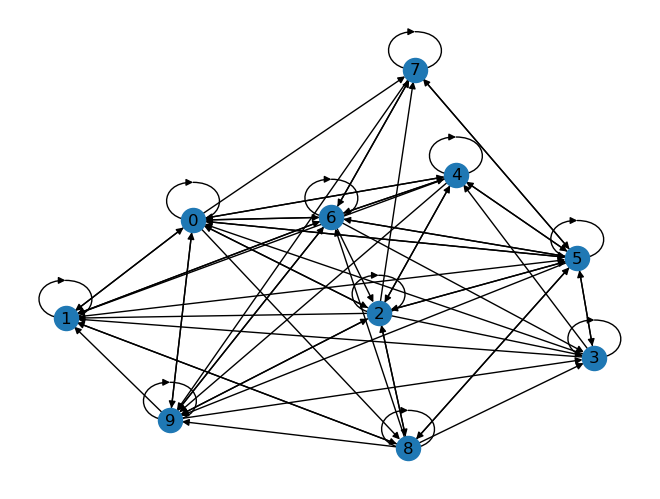

  0%|          | 0/1001 [00:00<?, ?it/s]

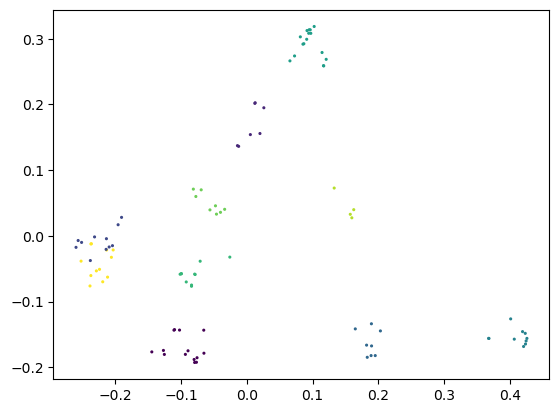

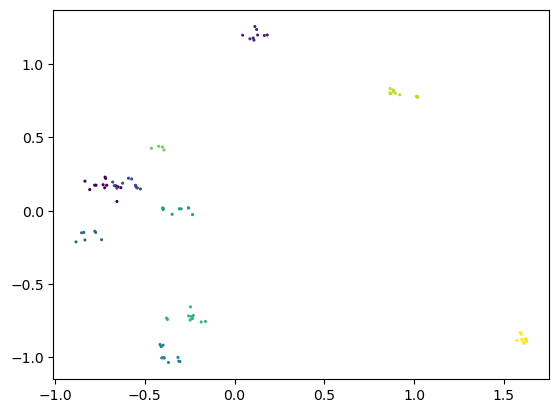

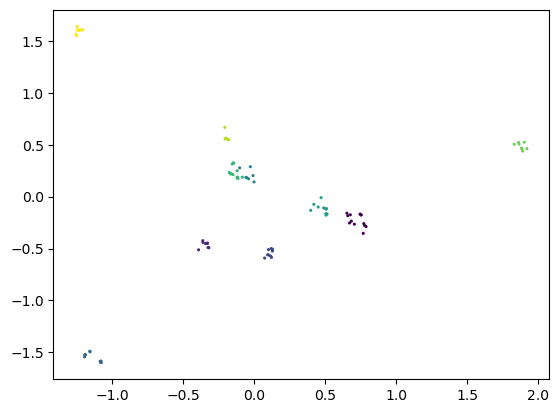

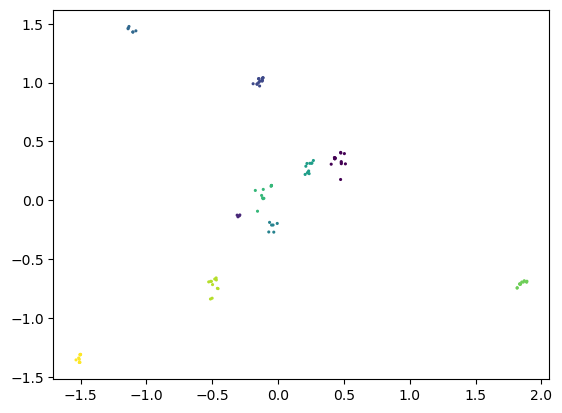

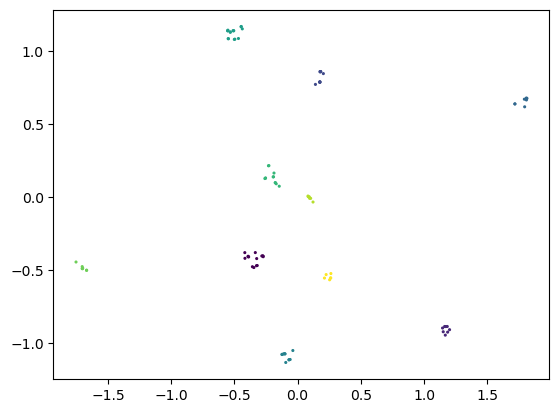

In [306]:
n = 10
#adj = torch.tensor([[0, 1, 0], [0, 0, 1], [1, 0, 0]])
g = Graph(n=n, alpha=0.7)
g.show()

rnn = SimpleRNN(hidden_size=10, learning_rate=1e-1, vocab_size=n+1)
rnn.train(g)